In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from xgboost import XGBClassifier
import dalex as dx
from yellowbrick.classifier import DiscriminationThreshold

In [5]:
def get_model_pipeline(model, numerical_cols, categorical_cols):
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='median')),
        ('normalization', MinMaxScaler())
    ])
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return model_pipeline

def train_and_evaluate_model(model, X, y, numerical_cols, categorical_cols, n_folds, tune_params=False, param_grid=None):
    y_pred_probs = np.array([])
    y_pred = np.array([])
    y_true = np.array([])

    if not tune_params:
        print("Training model with default hyperparameters...\n")

        cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2)

        for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            model_pipeline = get_model_pipeline(model, numerical_cols, categorical_cols)

            X_train_split, X_test_split = X.iloc[train_idx], X.iloc[test_idx]
            y_train_split, y_test_split = y.iloc[train_idx], y.iloc[test_idx]
            model_pipeline.fit(X_train_split, y_train_split)
            y_pred_prob_fold = model_pipeline.predict_proba(X_test_split)[:, 1]
            y_pred_fold = model_pipeline.predict(X_test_split)
            false_positive_rate, true_positive_rate, _ = roc_curve(y_test_split, y_pred_prob_fold)
            y_pred_probs = np.concatenate([y_pred_probs, y_pred_prob_fold])
            y_pred = np.concatenate([y_pred, y_pred_fold])
            y_true = np.concatenate([y_true, y_test_split])
            print(f"Fold {i}:")
            print(f"ROC AUC score: {roc_auc_score(y_test_split, y_pred_prob_fold)}\n")

        model_pipeline = get_model_pipeline(model, numerical_cols, categorical_cols)
        
        model_pipeline.fit(X, y)

        print(f"Total scores:")

        false_positive_rate, true_positive_rate, _ = roc_curve(y_true, y_pred_probs)
        total_roc_auc = roc_auc_score(y_true, y_pred_probs)
        print(f"ROC AUC score: {total_roc_auc}\n")
    elif tune_params and param_grid is not None:
        print("Tuning hyperparameters...\n")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

        best_params = tune_hyperparameters(model, param_grid, X_train, y_train, numerical_cols, categorical_cols, n_folds=3, scoring='roc_auc')
        model.set_params(**best_params)
        print(f"Model hyperparameters after tuning: {model.get_params()}")

        model_pipeline = get_model_pipeline(model, numerical_cols, categorical_cols)
        model_pipeline.fit(X_train, y_train)
        y_true = y_test
        y_pred_probs = model_pipeline.predict_proba(X_test)[:, 1]
        y_pred = model_pipeline.predict(X_test)

        print(f"Total scores:")

        false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred_probs)
        total_roc_auc = roc_auc_score(y_test, y_pred_probs)
        print(f"ROC AUC score: {total_roc_auc}\n")

    return y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, model_pipeline

def tune_hyperparameters(model, param_grid, X, y, numerical_cols, categorical_cols, n_folds, scoring='roc_auc'):
    model_pipeline = get_model_pipeline(model, numerical_cols, categorical_cols)
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=2)
    grid_search = GridSearchCV(estimator=model_pipeline, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1)
    grid_search.fit(X, y)
    print(f"Best hyperparameters: {grid_search.best_params_}")
    print(f"Best ROC AUC score: {grid_search.best_score_}\n")
    best_params = grid_search.best_params_
    best_params = {key.replace('classifier__', ''): value for key, value in best_params.items()}
    return best_params

def plot_roc(false_positive_rate, true_positive_rate, total_roc_auc):
    plt.figure(figsize=(6,5))
    plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=2, label=f'ROC (AUC = {total_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred=None, y_pred_probs=None, threshold=0.5):
    if y_pred_probs is not None:
        y_pred = (np.array(y_pred_probs) >= threshold).astype(int)
    if y_pred is None:
        raise ValueError("Provide either y_pred or y_pred_probs")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion matrix (threshold={threshold})')
    plt.show()

def plot_feature_importances(model, X, y):
    explainer = dx.Explainer(model, X, y)
    importances = explainer.model_parts()
    importances.plot()

def plot_discrimination_threshold(model, X, y):
    visualizer = DiscriminationThreshold(model)
    visualizer.fit(X, y)
    visualizer.show()

# Example

Tuning hyperparameters...

Best hyperparameters: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best ROC AUC score: 0.6795882717863323

Model hyperparameters after tuning: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs':

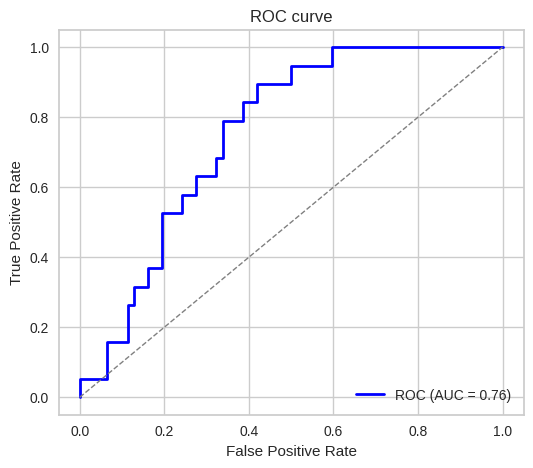

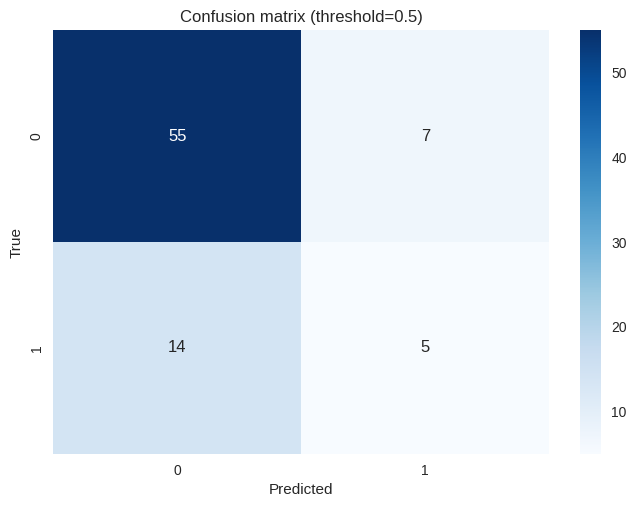

Preparation of a new explainer is initiated

  -> data              : 401 rows 15 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 401 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7dc9e12ab9c0> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00744, mean = 0.227, max = 0.888
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.724, mean = 0.00199, max = 0.938
  -> model_info        : package sklearn

A new explainer has been created!


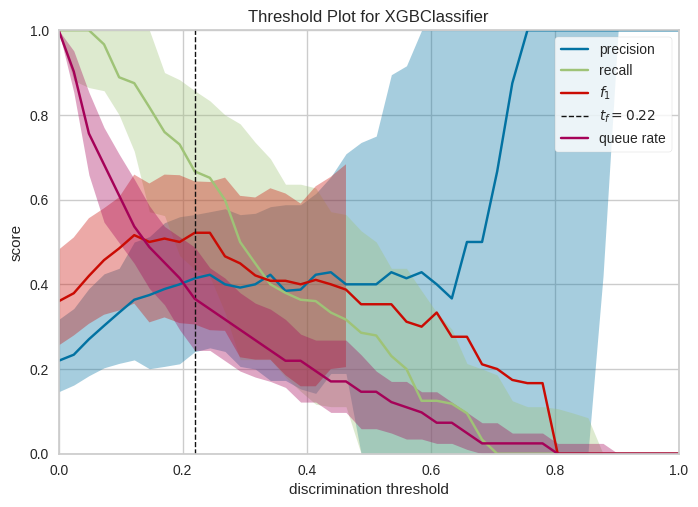

In [18]:
df = pd.read_csv('../materials/processed_df.csv')
df.head()

numerical_cols = ['wiek', 'PSA', 'PSAdensity', 'MRI vol', 'MRI SIZE']
categorical_cols = ['MRI EPE (naciek poza torebke)', 'MRI Pirads', 'MRI EPE L', 'MRI EPE P', 'MRI SVI (pecherzyki)', 'MRI SVI L', 'MRI SVI P','Bx ISUP Grade P', 'Bx ISUP Grade L', 'Bx ISUP Grade']

X = df[numerical_cols + categorical_cols]
y = df['EPE micro']

param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [200, 400, 800],
    'classifier__max_depth': [3, 4, 6],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2]
}
# param_grid = {
#     'classifier__learning_rate': [0.1],
#     'classifier__n_estimators': [200, 400],
#     'classifier__max_depth': [3, 4, 6],
#     'classifier__subsample': [0.8, 0.9, 1.0],
#     'classifier__colsample_bytree': [0.8, 0.9],
#     'classifier__gamma': [0, 0.1]
# }

untrained_model = XGBClassifier(random_state=2)

y_true, y_pred, y_pred_probs, false_positive_rate, true_positive_rate, total_roc_auc, trained_model = train_and_evaluate_model(untrained_model, X, y, numerical_cols, categorical_cols, n_folds=5, tune_params=True, param_grid=param_grid)
plot_roc(false_positive_rate, true_positive_rate, total_roc_auc)
plot_confusion_matrix(y_true, y_pred)
plot_feature_importances(trained_model, X, y)
plot_discrimination_threshold(untrained_model, X, y)

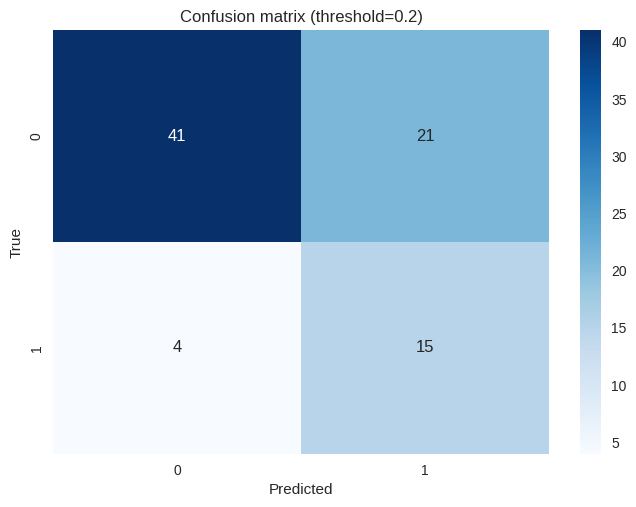

In [19]:
plot_confusion_matrix(y_true, y_pred_probs=y_pred_probs, threshold=0.2)